In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/eva-04/S9/')

Now we can import the library and use the function.

In [3]:
from __future__ import print_function
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from models import QuizDNN as quiz
from transformations import CIFARModel10_Alb as cifar
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

import importlib
#importlib.reload(quiz)
importlib.reload(cifar)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

SEED = 1
# CUDA?
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)



Files already downloaded and verified
Files already downloaded and verified
Current Date/Time:  2020-03-29 19:40:58.403476
Files already downloaded and verified
Files already downloaded and verified
cuda
CUDA Available? True


In [0]:
class QuizDNN(torch.nn.Module):
    def __init__(self, dropout_value = 0.1):
        """"Constructor of the class"""
        super(QuizDNN, self).__init__()
        # Input Block
        self.dropout_value = dropout_value
        #Depthwise separate 3 input channels into 3 output channels
        #it's first block uses following code:
        #x1 = Input
        #x2 = Conv(x1)
        #x3 = Conv(x1 + x2)
        #x4 = MaxPooling(x1 + x2 + x3)
        #x5 = Conv(x4)
        #x6 = Conv(x4 + x5)
        #x7 = Conv(x4 + x5 + x6)
        #x8 = MaxPooling(x5 + x6 + x7)
        #x9 = Conv(x8)
        #x10 = Conv (x8 + x9)
        #x11 = Conv (x8 + x9 + x10)
        #x12 = GAP(x11)
        #x13 = FC(x12)
        #Uses ReLU and BN wherever applicable
        #Uses CIFAR10 as the dataset
        #Your target is 75% in less than 40 Epochs
        #self.conv1 = nn.Conv2d(3, 6, 5)  # RF= 
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        #torch.nn.Conv2d(in_channels, out_channels=k*in_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        self.Conv0 = nn.Conv2d(3, 64, kernel_size=3, padding=1) #input 32*32*3, output=32*32*64
        
        self.Conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1) #input 32*32*64, output=32*32*64
        
        self.Conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1) #input 16*16*64, output=16*16*64
        
        self.Conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1) #input 8*8*64, output=8*8*64
        
        
        self.x2 = nn.Sequential( #input 32*32*64, output=32*32*64, RF=4
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        self.x3 = nn.Sequential(  #input 32*32*64, output=32*32*64, RF=6
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        
        self.x4 = nn.MaxPool2d(2, 2) #input 32*32*64, output=16*16*64, RF=7
        self.x5 = nn.Sequential( #input 16*16*64, output=16*16*64, RF=14
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        self.x6 = nn.Sequential( #input 16*16*64, output=16*16*64, RF=16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        self.x7 = nn.Sequential( #input 16*16*64, output=16*16*64, RF=18
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        
        self.x8 = nn.MaxPool2d(2, 2) #input 16*16*64, output_size = (8*8*64), RF=19
        self.x9 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=38
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        self.x10 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=40
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        self.x11 = nn.Sequential( #input 8*8*64, output_size = (8*8*64), RF=42
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            #nn.Dropout(dropout_value)
        )
        # OUTPUT BLOCK -> Add GAP Layer
        self.x12_gap = nn.Sequential( # input 8*8*64, output_size = (1*1*64), Receptive FieldF=42
            nn.AvgPool2d(kernel_size=8)
        )

        self.x13_fc = nn.Sequential(
            #nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
            nn.Linear(in_features=64, out_features=10)
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(self.dropout_value)

    def forward(self, x1):
        x2 = self.x2(x1)
        #print('x2=',len(x2))
        #x1_x2 = torch.cat((x1, x2), dim=1)
        x3 = self.x3(x2)
        #print('x3=',len(x3))
        #x1_x2_x3 = torch.cat((x2, x3),dim=2)
        x1_x2_x3 = x2.add(x3)
        x4 = self.x4(x1_x2_x3)
        #print('x4=',len(x4))
        x5 = self.x5(x4)
        #print('x5=',len(x5))
        #x4_x5 = torch.cat((x4, x5),dim=2)
        x4_x5 = x4.add(x5)
        x6 = self.x6(x4_x5)
        #print('x6=',len(x6))
        #x5_x6 = torch.cat((x5, x6),dim=2)
        x5_x6 = x5.add(x6)
        #x4_x5_x6 = torch.cat((x4, x5_x6),dim=2)
        x4_x5_x6 = x4.add(x5_x6)
        x7 = self.x7(x4_x5_x6)
        #print('x7=',len(x7))
        #x5_x6_x7 = torch.cat((x5_x6, x7),dim=2)
        x5_x6_x7 = x5_x6.add(x7)
        x8 = self.x8(x5_x6_x7)
        #print('x8=',len(x8))
        x9 = self.x9(x8)
        #print('x9=',len(x9))
        #x8_x9 = torch.cat((x8, x9),dim=2)
        x8_x9 = x8.add(x9)
        x10 = self.x10(x8_x9)
        #print('x10=',len(x10))
        #x8_x9_x10 = torch.cat((x8_x9, x10),dim=2)
        x8_x9_x10 = x8_x9.add(x10)
        x11 = self.x11(x8_x9_x10)
        #print('x11=',len(x11))
        x12 = self.x12_gap(x11)
        #print('x12=',len(x12))
        x12 = x12.view(-1, 64)
        x13 = self.x13_fc(x12)
        #print('x13=',len(x13))
        x13 = x13.view(-1, 10)
        #print('x13=',len(x13))
        #x14 = x13.view(-1, 10)
        return F.log_softmax(x13, dim=-1)
        

RUNNING WITH REGULARIZATION

In [4]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

from utils.global_fun import test_model
from utils.global_fun import train_model
from utils.global_fun import show_summary, run_model_with_entropy,  draw_accuracy_loss_change_graps

from models import QuizDNN as quiz
from transformations import CIFARModel10_Alb as cifar10_alb
from torchvision import datasets, transforms
import numpy as np
#images=datasets.CIFAR10(root='./data', train=True, download=True)

import importlib
importlib.reload(quiz)
importlib.reload(cifar10_alb)
#image_size=np.transpose(images.data[0], (2, 0, 1)).shape
#print('data size',image_size)
model = quiz.QuizDNN().to(device)
cifar_model = cifar10_alb.CIFARModel10_Alb(model)
show_summary(cifar_model,input_size=(3,32,32))


Current Date/Time:  2020-03-29 19:41:17.906902
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 

RUN MODEL

In [5]:
  run_model_with_entropy(cifar_model, device, doL1= 1, doL2=1, LAMBDA=0.0005, EPOCHS=10)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 0


Loss=6.573999404907227 Batch_id=195 Accuracy=24.13: 100%|██████████| 196/196 [00:24<00:00,  7.94it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 3243/10000 (32.43%)

EPOCH: 1
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 1


Loss=6.487653732299805 Batch_id=195 Accuracy=31.68: 100%|██████████| 196/196 [00:24<00:00,  7.89it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 3704/10000 (37.04%)

EPOCH: 2
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 2


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 4176/10000 (41.76%)

EPOCH: 3
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 3


Loss=6.473464488983154 Batch_id=195 Accuracy=38.00: 100%|██████████| 196/196 [00:24<00:00,  7.91it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 4363/10000 (43.63%)

EPOCH: 4
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 4


Loss=6.070728302001953 Batch_id=195 Accuracy=40.32: 100%|██████████| 196/196 [00:24<00:00,  7.87it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 4542/10000 (45.42%)

EPOCH: 5
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 5


Loss=6.306812286376953 Batch_id=195 Accuracy=41.47: 100%|██████████| 196/196 [00:24<00:00,  7.84it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 4689/10000 (46.89%)

EPOCH: 6
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 6


Loss=6.379049301147461 Batch_id=195 Accuracy=43.21: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 4937/10000 (49.37%)

EPOCH: 7
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 7


Loss=6.4244842529296875 Batch_id=195 Accuracy=44.42: 100%|██████████| 196/196 [00:24<00:00,  7.89it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 4999/10000 (49.99%)

EPOCH: 8
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 8


Loss=6.00677490234375 Batch_id=195 Accuracy=45.18: 100%|██████████| 196/196 [00:24<00:00,  7.84it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 5122/10000 (51.22%)

EPOCH: 9
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 9


Loss=6.011021614074707 Batch_id=195 Accuracy=46.20: 100%|██████████| 196/196 [00:24<00:00,  7.89it/s]



Test set: Average loss: 0.0054, Accuracy: 5063/10000 (50.63%)



In [0]:
run_model_with_entropy(cifar_model, device, doL1= 1, doL2=1, LAMBDA=0.0005, EPOCHS=40)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 0


Loss=6.202662467956543 Batch_id=195 Accuracy=46.84: 100%|██████████| 196/196 [00:25<00:00,  7.79it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 5328/10000 (53.28%)

EPOCH: 1
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 1


Loss=6.234321117401123 Batch_id=195 Accuracy=47.62: 100%|██████████| 196/196 [00:25<00:00,  7.77it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 5363/10000 (53.63%)

EPOCH: 2
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 2


Loss=6.083927631378174 Batch_id=195 Accuracy=48.50: 100%|██████████| 196/196 [00:25<00:00,  7.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 5592/10000 (55.92%)

EPOCH: 3
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 3


Loss=6.039504528045654 Batch_id=195 Accuracy=49.18: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 5420/10000 (54.20%)

EPOCH: 4
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 4


Loss=6.183037757873535 Batch_id=195 Accuracy=49.80: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 5546/10000 (55.46%)

EPOCH: 5
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 5


Loss=6.009486675262451 Batch_id=195 Accuracy=50.32: 100%|██████████| 196/196 [00:25<00:00,  7.67it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 5875/10000 (58.75%)

EPOCH: 6
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 6


Loss=6.2611799240112305 Batch_id=195 Accuracy=51.23: 100%|██████████| 196/196 [00:25<00:00,  7.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 5871/10000 (58.71%)

EPOCH: 7
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 7


Loss=6.044390678405762 Batch_id=195 Accuracy=51.67: 100%|██████████| 196/196 [00:25<00:00,  7.80it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 5810/10000 (58.10%)

EPOCH: 8
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 8


Loss=6.078238487243652 Batch_id=195 Accuracy=52.14: 100%|██████████| 196/196 [00:25<00:00,  7.81it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 5832/10000 (58.32%)

EPOCH: 9
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 9


Loss=5.7765350341796875 Batch_id=195 Accuracy=52.65: 100%|██████████| 196/196 [00:25<00:00,  7.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 5895/10000 (58.95%)

EPOCH: 10
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 10


Loss=5.8741960525512695 Batch_id=195 Accuracy=52.97: 100%|██████████| 196/196 [00:25<00:00,  7.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 6028/10000 (60.28%)

EPOCH: 11
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 11


Loss=5.937008857727051 Batch_id=195 Accuracy=53.87: 100%|██████████| 196/196 [00:25<00:00,  7.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 6143/10000 (61.43%)

EPOCH: 12
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 12


Loss=5.833797931671143 Batch_id=195 Accuracy=53.81: 100%|██████████| 196/196 [00:24<00:00,  7.84it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 6143/10000 (61.43%)

EPOCH: 13
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 13


Loss=5.953242301940918 Batch_id=195 Accuracy=54.49: 100%|██████████| 196/196 [00:25<00:00,  7.79it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 6089/10000 (60.89%)

EPOCH: 14
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 14


Loss=5.88063907623291 Batch_id=195 Accuracy=54.72: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 6115/10000 (61.15%)

EPOCH: 15
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 15


Loss=5.997598648071289 Batch_id=195 Accuracy=55.08: 100%|██████████| 196/196 [00:24<00:00,  7.87it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 6322/10000 (63.22%)

EPOCH: 16
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 16


Loss=6.017971992492676 Batch_id=195 Accuracy=55.90: 100%|██████████| 196/196 [00:24<00:00,  7.88it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 6157/10000 (61.57%)

EPOCH: 17
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 17


Loss=6.112896919250488 Batch_id=195 Accuracy=56.16: 100%|██████████| 196/196 [00:24<00:00,  7.86it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 6230/10000 (62.30%)

EPOCH: 18
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 18


Loss=5.805387496948242 Batch_id=195 Accuracy=56.40: 100%|██████████| 196/196 [00:24<00:00,  7.87it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 6382/10000 (63.82%)

EPOCH: 19
L1= 1 ;L2= 1 ;LAMBDA= 0.0005 epoch= 19


Loss=5.815315246582031 Batch_id=123 Accuracy=56.73:  63%|██████▎   | 124/196 [00:16<00:08,  8.47it/s]

ACCURACY , LOSS CHANGE GRAPHS


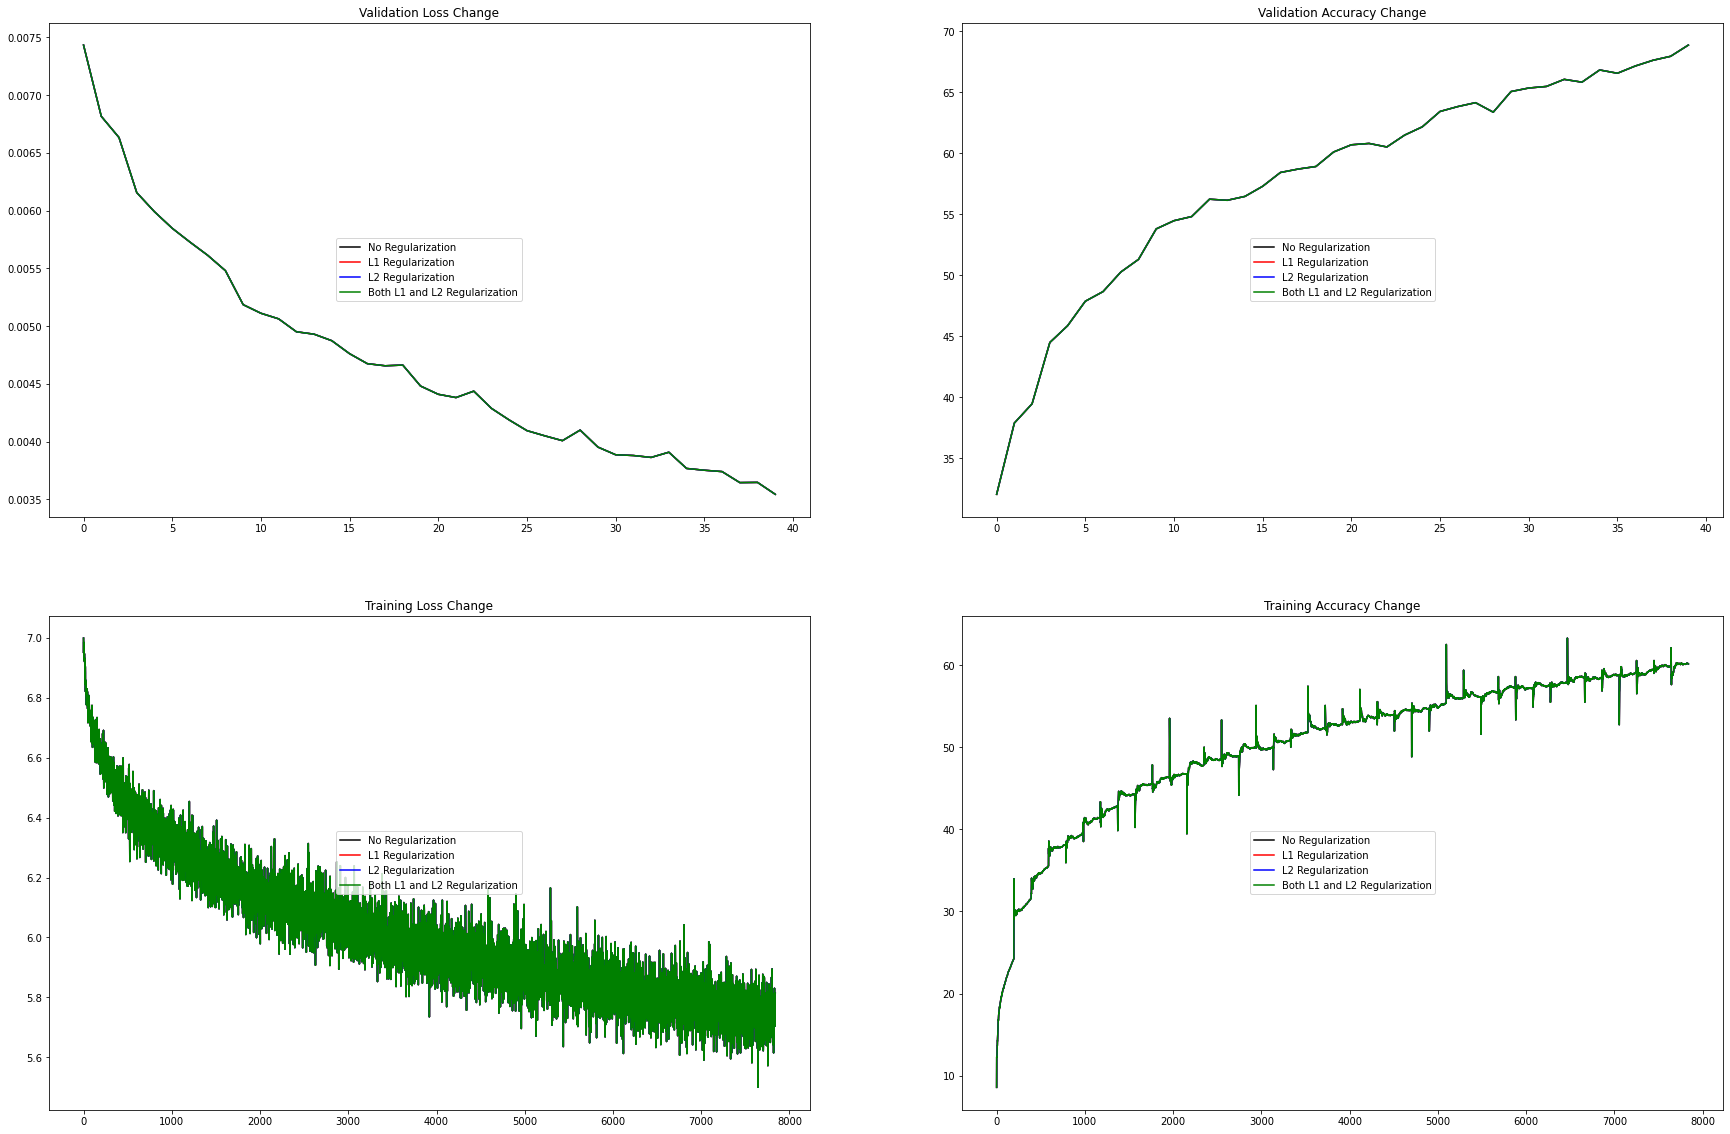

In [6]:
draw_accuracy_loss_change_graps(cifar_model,cifar_model,cifar_model,cifar_model)

GRADCAM VISUALIZATION

PRINT MODAL STATE DICT

In [7]:
for param_tensor in cifar_model.m_model.state_dict():
    print(param_tensor, "\t", cifar_model.m_model.state_dict()[param_tensor].size())

Conv0.weight 	 torch.Size([64, 3, 3, 3])
Conv0.bias 	 torch.Size([64])
Conv1.weight 	 torch.Size([64, 64, 3, 3])
Conv1.bias 	 torch.Size([64])
Conv2.weight 	 torch.Size([64, 64, 3, 3])
Conv2.bias 	 torch.Size([64])
Conv3.weight 	 torch.Size([64, 64, 3, 3])
Conv3.bias 	 torch.Size([64])
x2.0.weight 	 torch.Size([64, 3, 3, 3])
x2.0.bias 	 torch.Size([64])
x2.2.weight 	 torch.Size([64])
x2.2.bias 	 torch.Size([64])
x2.2.running_mean 	 torch.Size([64])
x2.2.running_var 	 torch.Size([64])
x2.2.num_batches_tracked 	 torch.Size([])
x3.0.weight 	 torch.Size([64, 64, 3, 3])
x3.0.bias 	 torch.Size([64])
x3.2.weight 	 torch.Size([64])
x3.2.bias 	 torch.Size([64])
x3.2.running_mean 	 torch.Size([64])
x3.2.running_var 	 torch.Size([64])
x3.2.num_batches_tracked 	 torch.Size([])
x5.0.weight 	 torch.Size([64, 64, 3, 3])
x5.0.bias 	 torch.Size([64])
x5.2.weight 	 torch.Size([64])
x5.2.bias 	 torch.Size([64])
x5.2.running_mean 	 torch.Size([64])
x5.2.running_var 	 torch.Size([64])
x5.2.num_batches_trac

OPTIMIZER STATE DICT

In [8]:
for var_name in cifar_model.m_optimizer.state_dict():
    print(var_name, "\t", cifar_model.m_optimizer.state_dict()[var_name])

state 	 {139701129831120: {'momentum_buffer': tensor([[[[ 6.1651e-02,  9.6702e-02,  4.9740e-02],
          [ 7.4970e-02,  8.3711e-02,  2.6705e-02],
          [ 1.0107e-01,  8.5296e-02,  1.8405e-02]],

         [[ 7.3050e-02,  1.0315e-01,  5.8817e-02],
          [ 9.4122e-02,  9.8507e-02,  3.8431e-02],
          [ 1.2488e-01,  1.0390e-01,  3.3240e-02]],

         [[ 9.5821e-02,  1.1735e-01,  7.6134e-02],
          [ 1.1223e-01,  1.0665e-01,  4.2627e-02],
          [ 1.3238e-01,  1.0741e-01,  3.0904e-02]]],


        [[[-1.5217e-02,  5.7138e-04,  1.4385e-02],
          [-2.3815e-02, -1.7627e-02, -1.2582e-02],
          [-2.2741e-02, -1.5753e-02, -6.1913e-03]],

         [[ 5.2789e-03,  1.9132e-02,  2.8735e-02],
          [-7.4626e-03, -5.1728e-05,  1.7806e-03],
          [-3.3308e-03,  3.7770e-03,  7.2851e-03]],

         [[-4.7435e-03,  9.1971e-03,  2.0095e-02],
          [-1.7356e-02, -1.1614e-02, -5.8378e-03],
          [-8.5988e-03, -2.5364e-03,  3.0816e-03]]],


        [[[-1.5857e-